In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
# from flax import linen as nn
# from typing import Sequence
# import jax
# from jax import vmap, jit   
# import os
# import jax.numpy as jnp
# import jax.random as random
# import numpyro
# import numpyro.distributions as dist
# from numpyro.infer import (SVI, Trace_ELBO, autoguide, init_to_median, NUTS, MCMC, TraceMeanField_ELBO)
# import pandas as pd
# # from numpyro.infer import SVI, Trace_ELBO
# from numpyro.infer.autoguide import AutoNormal
# from numpyro.infer.util import Predictive, log_density 
# from sklearn.model_selection import train_test_split

# #%% Environment and/or CUDA commands
# os.environ["CUDA_VISIBLE_DEVICES"] = "6"
# os.environ['XLA_FLAGS']="--xla_gpu_force_compilation_parallelism=1" # This is required until they update some things on PIBE
# numpyro.enable_x64(use_x64=True)

## Read and set up example airfoil

In [2]:
"""read files"""
x_data_raw = pd.read_csv('./data/XFOIL_BNN_train.csv',header=None)
Cp_data_raw = pd.read_csv('./data/XFOIL_BNN_values.csv',header=None)
airfoils_raw = pd.read_csv('./data/XFOIL_BNN_ref.csv',header=None) # Name values
airfoilName = np.array(airfoils_raw.values.reshape((-1,1)))

"""select specfic airfoil"""
afIndex = 212#28
x = x_data_raw.values.T[afIndex, :300]
y = x_data_raw.values.T[afIndex, 300:600]
cp = Cp_data_raw.values.T[afIndex, :]
airfoil = airfoilName[afIndex]

"""plot selected airfoil"""
f, ax = plt.subplots(1,2, figsize=(12, 5))
# plot coordiantes
ax[0].plot(x, y, 'k-')
ax[0].title.set_text(airfoil[0] + ' profile')
ax[0].set_xlabel('x/c')
ax[0].set_ylabel('y/c')
ax[0].axis('equal')
# plot pressure distribution
ax[1].plot(x, cp)
ax[1].title.set_text(airfoil[0] + ' pressure distribution')
ax[1].set_xlabel('x/c')
ax[1].set_ylabel('$C_p$')
ax[1].invert_yaxis()
plt.close()

## Set up Bezier function

In [24]:
from scipy.special import comb
import scipy 

def get_bezier_parameters(X, Y, degree=3):
    """ Least square qbezier fit using penrose pseudoinverse.

    Parameters:

    X: array of x data.
    Y: array of y data. Y[0] is the y point for X[0].
    degree: degree of the Bézier curve. 2 for quadratic, 3 for cubic.
    """
    if degree < 1:
        raise ValueError('degree must be 1 or greater.')

    if len(X) != len(Y):
        raise ValueError('X and Y must be of the same length.')

    if len(X) < degree + 1:
        raise ValueError(f'There must be at least {degree + 1} points to '
                         f'determine the parameters of a degree {degree} curve. '
                         f'Got only {len(X)} points.')

    def bpoly(n, t, k):
        """ Bernstein polynomial when a = 0 and b = 1. """
        
        return t ** k * (1 - t) ** (n - k) * comb(n, k)
        #return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

    def bmatrix(T):
        """ Bernstein matrix for Bézier curves. """
        return np.matrix([[bpoly(degree, t, k) for k in range(degree + 1)] for t in T])

    def least_square_fit(points, M):
        M_ = np.linalg.pinv(M)
        return M_ * points

    T = np.linspace(0, 1, len(X))
    M = bmatrix(T)
    points = np.array(list(zip(X, Y)))
    
    final = least_square_fit(points, M)#.tolist()
    # final[0] = [X[0], Y[0]]
    # final[len(final)-1] = [X[len(X)-1], Y[len(Y)-1]]
    return final

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return scipy.special.comb(n, i) * ( t**i ) * (1 - t)**(n-i)

def bezier_curve(points, interp_loc):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = interp_loc 
    polynomial_array = np.array([bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

class bezier_airfoil_fit:
    def __init__(self, X, Y, y): 
        num_ctrl_pts = y.shape[0]+2 # + LE and TE conditions
        # Conditions, start point, [0, y_1], ..., end point
        ctrl_x = np.linspace(0.0, X[-1], num_ctrl_pts-1)[:-1] # Control points to be optimized 
        ctrl_x = np.hstack((0.0, ctrl_x, X[-1]))
        ctrl_y = np.hstack((0.0, y, Y[-1])) # 0.0, 
        ctrl_pts = np.hstack((ctrl_x[:,None], ctrl_y[:,None]))    
        
        self.X = X 
        self.Y = Y 
        self.ctrl_pts = ctrl_pts
        self.curve = bezier_curve(ctrl_pts, self.X)
    
    
    def update(self, new_input):
        num_ctrl_pts = new_input.shape[0]+2
        # Conditions, start point, [0, y_1], ..., end point
        ctrl_x = np.linspace(0.0, self.X[-1], num_ctrl_pts-1)[:-1] # Control points to be optimized 
        ctrl_x = np.hstack((0.0, ctrl_x, self.X[-1])) # Constraints at LE and TE 
        ctrl_y = np.hstack((0.0, new_input, self.Y[-1])) # 0.0, 
        ctrl_pts = np.hstack((ctrl_x[:,None], ctrl_y[:,None]))   
        
        self.ctrl_pts = ctrl_pts
        self.curve = bezier_curve(ctrl_pts, self.X)
        interp_Y = np.interp(self.curve[0], self.X, self.Y)
        self.loss = np.sqrt(np.mean((self.curve[1]-interp_Y)**2)) # Fix this to be more robust
        # print(self.loss.shape)
        return self.loss
    
class bezier_pressure_fit:
    def __init__(self, X, Y, y): 
        num_ctrl_pts = y.shape[0]+2 # + LE and TE conditions
        # Conditions, start point, [0, y_1], ..., end point
        ctrl_x = np.linspace(0.0, X[-1], y.shape[0]+1)[:-1] * np.pi/2 # Control points to be optimized 
        ctrl_x = np.hstack((X[0], 1-np.cos(ctrl_x), X[-1]))
        ctrl_y = np.hstack((Y[0], y, Y[-1])) # 0.0, 
        ctrl_pts = np.hstack((ctrl_x[:,None], ctrl_y[:,None]))    
        
        self.X = X 
        self.Y = Y 
        self.ctrl_pts = ctrl_pts
        self.curve = bezier_curve(ctrl_pts, self.X)
    
    
    def update(self, new_input):
        num_ctrl_pts = new_input.shape[0]+2
        # Conditions, start point, [0, y_1], ..., end point
        ctrl_x = np.linspace(0.0, self.X[-1], new_input.shape[0]+1)[:-1] * np.pi/2 # Control points to be optimized 
        ctrl_x = np.hstack((self.X[0], 1-np.cos(ctrl_x), self.X[-1]))
        ctrl_y = np.hstack((self.Y[0], new_input, self.Y[-1])) # 0.0, 
        ctrl_pts = np.hstack((ctrl_x[:,None], ctrl_y[:,None]))    
        
        self.ctrl_pts = ctrl_pts
        self.curve = bezier_curve(ctrl_pts, self.X)
        interp_Y = np.interp(self.curve[0], self.X, self.Y)
        self.loss = np.sqrt(np.mean((self.curve[1]-interp_Y)**2)) # Fix this to be more robust
        # print(self.loss.shape)
        return self.loss

## Application - airfoil profile

Example of doing Bezier fit on airfoil profile

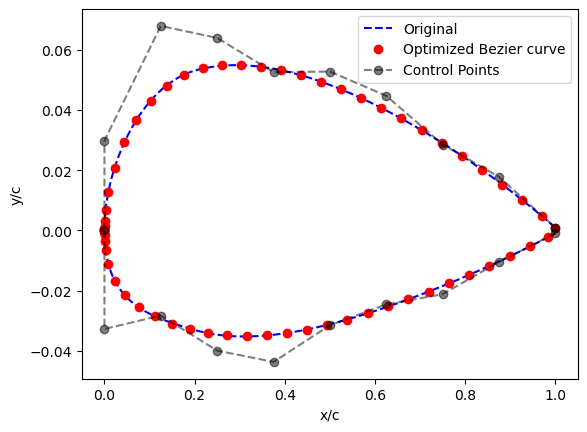

In [4]:
zeroLoc = np.argwhere(np.diff(x)<= 0.0)[-1][0]
x_u = x[:zeroLoc+1].flatten()
x_l = x[zeroLoc+1:].flatten()
y_u = y[:zeroLoc+1].flatten()
y_l = y[zeroLoc+1:].flatten()

X1 = np.flip(x_u)
Y1 = np.flip(y_u)
X2 = x_l
Y2 = y_l 

from scipy.optimize import  least_squares

num_opt_pt = 8
fit_upper = bezier_airfoil_fit(X1, Y1, np.ones(num_opt_pt)*np.max(Y1)) # initialize
res_upper = least_squares(fit_upper.update, np.ones(num_opt_pt)*np.max(Y1))
fit_lower = bezier_airfoil_fit(X2, Y2, np.ones(num_opt_pt)*np.max(Y2)) # initialize
res_lower = least_squares(fit_lower.update, np.ones(num_opt_pt)*np.max(Y2))

plt.figure()
plt.plot(x, y, 'b--', label='Original')
plt.plot(fit_upper.curve[0][::5], fit_upper.curve[1][::5],'ro', label = 'Optimized Bezier curve')
plt.plot(fit_upper.ctrl_pts[:,0], fit_upper.ctrl_pts[:,1], 'ko--', alpha = 0.5, label = 'Control Points')
plt.plot(fit_lower.curve[0][::5], fit_lower.curve[1][::5],'ro')
plt.plot(fit_lower.ctrl_pts[:,0], fit_lower.ctrl_pts[:,1], 'ko--', alpha = 0.5)
plt.xlabel('x/c')
plt.ylabel('y/c')
plt.legend()


Trend study

Text(0, 0.5, 'Total RMSE')

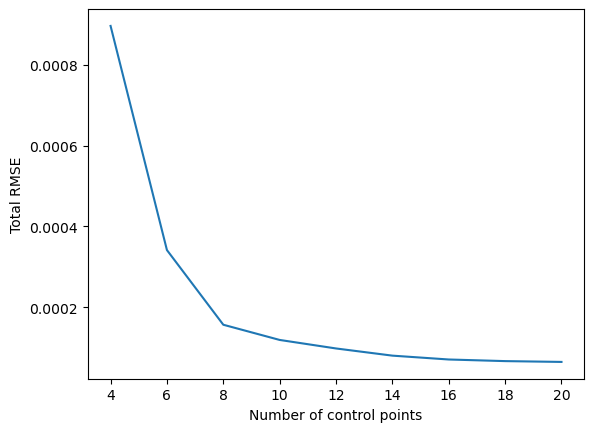

In [5]:
rmse = []
degree_range = np.arange(2, 20, 2)
for i in degree_range:
    num_opt_pt = i
    fit_upper = bezier_airfoil_fit(X1, Y1, np.ones(num_opt_pt)*np.max(Y1)) # initialize
    res_upper = least_squares(fit_upper.update, np.ones(num_opt_pt)*np.max(Y1))
    fit_lower = bezier_airfoil_fit(X2, Y2, np.ones(num_opt_pt)*np.max(Y2)) # initialize
    res_lower = least_squares(fit_lower.update, np.ones(num_opt_pt)*np.max(Y2))
    rmse.append((fit_upper.loss + fit_lower.loss)/2)

plt.plot(degree_range+2, rmse)
plt.xlabel('Number of control points')
plt.ylabel('Total RMSE')

## Application - pressure coefficients

Example of doing Bezier fit on pressure coefficients 

In [43]:
zeroLoc = np.argwhere(np.diff(x)<= 0.0)[-1][0]
x_u = x[:zeroLoc+1].flatten()
x_l = x[zeroLoc+1:].flatten()
cp_u = cp[:zeroLoc+1].flatten()
cp_l = cp[zeroLoc+1:].flatten()

X1 = np.flip(x_u)
Y1 = np.flip(cp_u)
X2 = x_l
Y2 = cp_l 

num_opt_pt_u = 28
num_opt_pt_l = 8
fit_upper = bezier_pressure_fit(X1, Y1, np.ones(num_opt_pt_u)*-1) # initialize
res_upper = least_squares(fit_upper.update, np.ones(num_opt_pt_u)*-1)
fit_lower = bezier_pressure_fit(X2, Y2, np.ones(num_opt_pt_l)) # initialize
res_lower = least_squares(fit_lower.update, np.ones(num_opt_pt_l))

plt.figure() 
plt.plot(x, cp, 'b--', label='Original')
plt.plot(fit_upper.curve[0][::5], fit_upper.curve[1][::5],'rs', label = 'Optimized Bezier curve')
plt.plot(fit_upper.ctrl_pts[:,0], fit_upper.ctrl_pts[:,1], 'ks--', alpha = 0.5, label = 'Control Points')
plt.plot(fit_lower.curve[0][::5], fit_lower.curve[1][::5],'rx')
plt.plot(fit_lower.ctrl_pts[:,0], fit_lower.ctrl_pts[:,1], 'kx--', alpha = 0.5)
plt.xlabel('x/c')
plt.ylabel('y/c')
plt.legend()
plt.ylim([-2.5,1.5])

Trend study

4
5
6
7
8
9
10
11
12
13
14


Text(0, 0.5, 'Total RMSE - Lower surface')

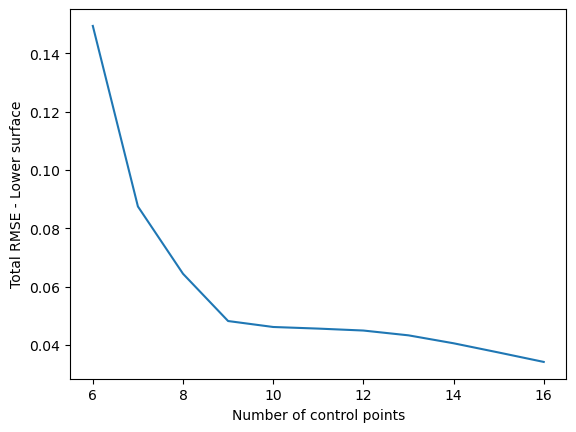

In [ ]:
"""Lower surface trend study"""
rmse = []
degree_range = np.arange(4, 15, 1)
for i in degree_range:
    num_opt_pt = i
    fit_lower = bezier_pressure_fit(X2, Y2, np.ones(num_opt_pt)) # initialize
    res_lower = least_squares(fit_lower.update, np.ones(num_opt_pt))
    rmse.append(fit_lower.loss)

plt.figure()
plt.plot(degree_range+2, rmse)
plt.xlabel('Number of control points')
plt.ylabel('Total RMSE - Lower surface')

18
19
20
21
22
23
24
25
26
27
28
29


Text(0, 0.5, 'Total RMSE - Upper surface')

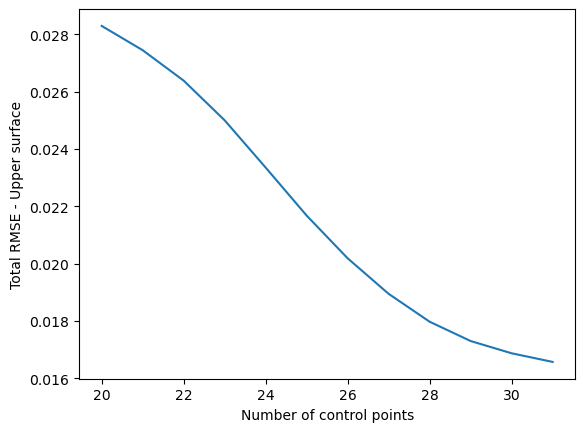

In [40]:
"""Upper surface trend study"""
rmse = []
degree_range = np.arange(18, 30, 1)
for i in degree_range:
    num_opt_pt = i
    fit_upper = bezier_pressure_fit(X1, Y1, np.ones(num_opt_pt)*-1) # initialize
    res_upper = least_squares(fit_upper.update, np.ones(num_opt_pt)*-1)
    rmse.append(fit_upper.loss)

plt.figure()
plt.plot(degree_range+2, rmse)
plt.xlabel('Number of control points')
plt.ylabel('Total RMSE - Upper surface')